In [1]:
import os
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
from matplotlib import pyplot as plt
import traceHMM.model as trm
import traceHMM.utils.plot as tplt

In [2]:
%reload_ext autoreload
%autoreload 2

### Notations

Let $\mathbf X \in \mathbb R^{N\times T}$ denote the spatial distance between two loci. The $nt$th entry of $\mathbf X$, denoted by $X_t^n$, represents the spatial distance of the $n$th trace at timepoint $t$. Define the notation for hidden state similarly as $\mathbf H \in \mathbb R^{N\times T}$ and $H_t^n$. In this section, we assume the Markov chain jumps between $S$ states, so $H_t^n \in \{1, ..., S\}$. In our paper, we assume $S = 3$, but the model works for arbitrary number of states. Further, we define $m_t^n \in \{1, 0\}$ to indicate whether $X_t^n$ is observed ($m_t^n = 1$ if $X_t^n$ is observed, otherwise $0$).

We further define the PDF of spatial distance $x$ at state $s \in \{1, ..., S\}$ as $f_s(x)$. For the Markov chain, define the initial distribution and transition probability as
$$
\vec\mu = \begin{bmatrix}
\mathbb P(H_1 = 1) \\ \cdots \\ \mathbb P(H_1 = S)
\end{bmatrix}\qquad\text{and}\qquad
\mathbf P = 
\begin{bmatrix}
\mathbb P(H_{t+1} = 1|H_t = 1) & \mathbb P(H_{t+1} = 2|H_t = 1) & \cdots \\
\mathbb P(H_{t+1} = 1|H_t = 2) & \mathbb P(H_{t+1} = 2|H_t = 2) & \cdots \\
\vdots & \vdots & \ddots
\end{bmatrix}
$$
We write $\mathbb P(H_1 = s)$ as $\mu(s)$ and $\mathbb P(H_{t+1} = s_2|H_t = s_1)$ as $P(s_1, s_2)$ to abbreviate the notations.

In our model, we assume $f_s(x)$ is known before fitting the HMM, so the parameters of $f_s(x)$ are not updated. This allows pre-specified values for the looped and unlooped status. For example, one can fix the loop state mean to $200$nm to ensure consistent prediction of loop state across different datasets. In the end, the fitting procedure described below is used to determine $\vec\mu$ and $\mathbf P$ only. This reduction of estimable parameters also facilitates stable estimation across different runs.

In addition, we allow some entries of the transition matrix to be fixed. For example, one can fix $P(1, 3) = 0$, which means the loop state cannot jump directly to the unloop state but must pass through the intermediate state first. This additional flexibility makes it possible to incorporate more biological background to the model, thus improving prediction results.

## Test by Simulations

In [3]:
P = np.array([
    [0.95, 0.05,    0],
    [0.02, 0.96, 0.02],
    [   0, 0.05, 0.95]
])
err = np.diag(np.square([0.06, 0.06, .12])*2)
dist_params = (
        {"cov":np.diag(np.ones(3)*0.015), "err":err},
        {"cov":np.diag(np.ones(3)*0.055), "err":err},
        {"cov":np.diag(np.ones(3)*0.085), "err":err}
)
tse = trm.TraceSimulator(
    P=P,
    mu=np.array([1/3, 1/3, 1/3]),
    dist_params=dist_params,
    dist_type=trm.multivariate_normal,
    random_state=100
)
H, X0 = tse.simulate_multiple_traces(500, 400)
X = tse.mask_by_markov_chain(X0, 0.5, a=0.8)

P(stay observed) = 0.8


In [4]:
dist_params = (
        {"cov":np.diag(np.ones(3)*0.015)},
        {"cov":np.diag(np.ones(3)*0.055)},
        {"cov":np.diag(np.ones(3)*0.085)}
)
tm = trm.TraceModel(
    X=X, Pm=np.array([
        [-1, -1,  0],
        [-1, -1, -1],
        [ 0, -1, -1]
    ]), 
    dist_params=dist_params, 
    dist_type=trm.multivariate_normal, 
    update_dist_params=["err"]
)
tm.fit(600)

Converged at iteration 504


In [5]:
tm.loc_err

array([0.05237644, 0.05454736, 0.11672494])

<Axes: >

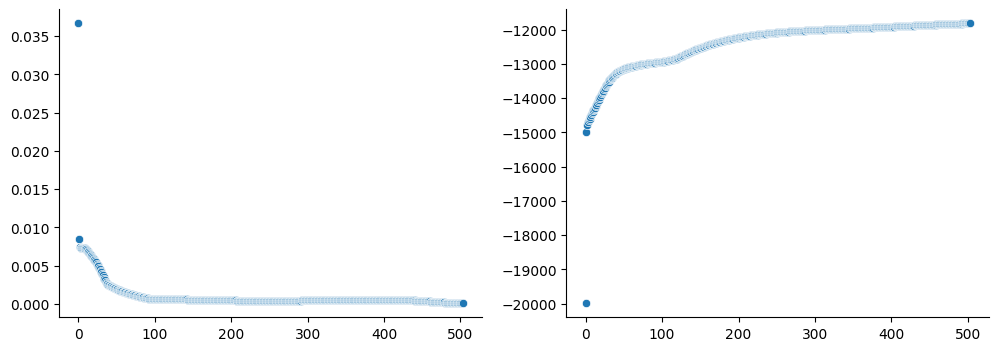

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.scatterplot(tm.convergence, ax=axes[0])
sns.scatterplot(tm.lklhd, ax=axes[1])

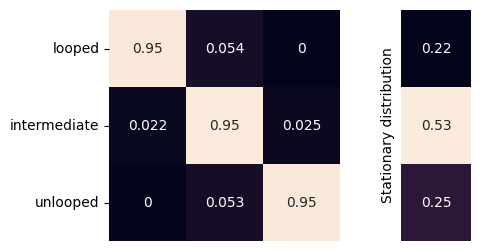

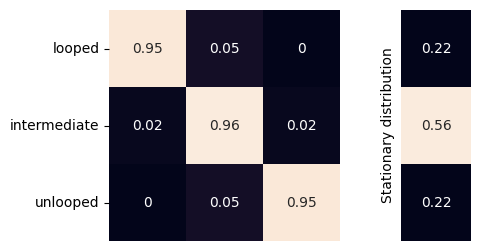

In [7]:
fig = tplt.plot_transition_matrix(tm.P)
fig = tplt.plot_transition_matrix(P)

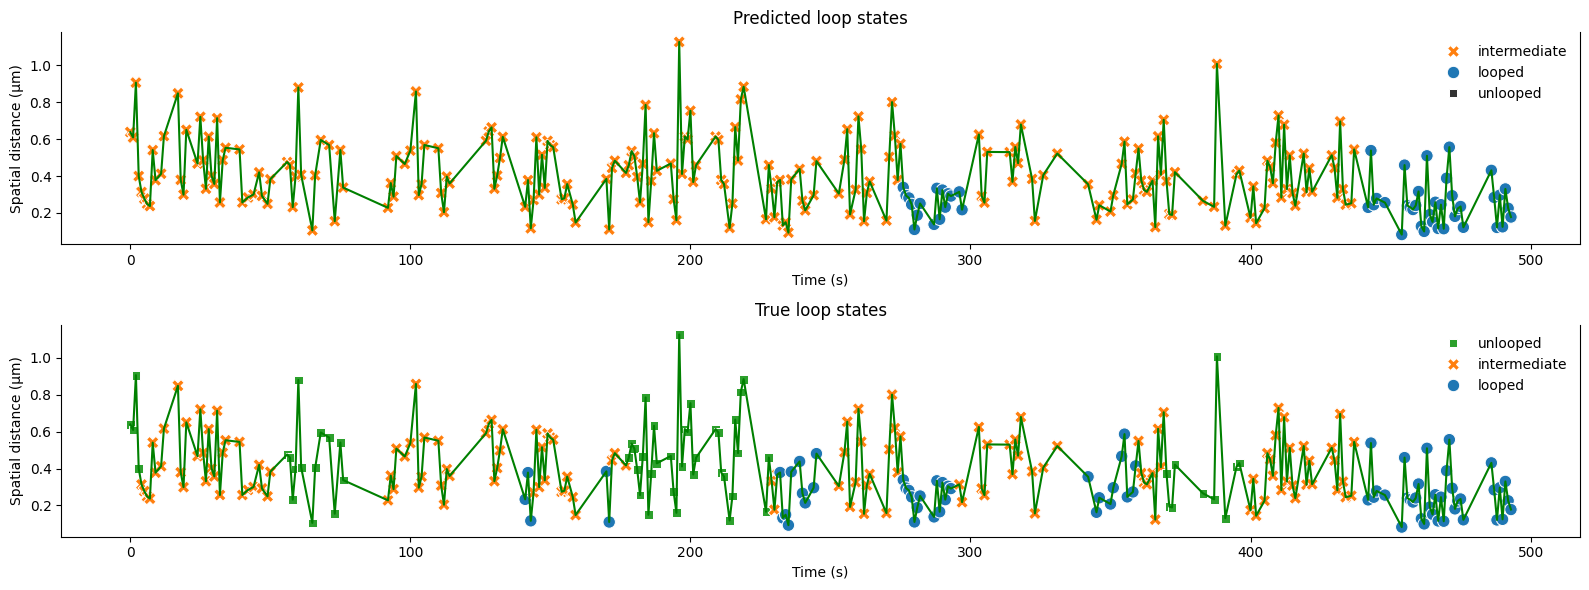

In [8]:
n = 1
dist = np.linalg.norm(X[n], axis=1)
df = pd.DataFrame({"dist":dist, "state":tm.decode(X[[n]])[0]})
df = df.reset_index(names="t")
df["true"] = H[n]
code_book = {0:"looped", 1:"intermediate", 2:"unlooped"}
fig, axes = plt.subplots(2, 1, figsize=(16, 6))
tplt.plot_trace(df, "t", "dist", "state", code_book, fig, axes[0])
tplt.plot_trace(df, "t", "dist", "true", code_book, fig, axes[1])
axes[0].set(xlabel="Time (s)", ylabel="Spatial distance (µm)", title="Predicted loop states")
axes[1].set(xlabel="Time (s)", ylabel="Spatial distance (µm)", title="True loop states")
fig.tight_layout()

### Ignore the localization error

In [9]:
dist_params = (
        {"cov":np.diag(np.ones(3)*0.015)},
        {"cov":np.diag(np.ones(3)*0.055)},
        {"cov":np.diag(np.ones(3)*0.085)}
)
tm2 = trm.TraceModel(
    X=X, Pm=np.array([
        [-1, -1,  0],
        [-1, -1, -1],
        [ 0, -1, -1]
    ]), 
    dist_params=dist_params, 
    dist_type=trm.multivariate_normal, 
)
tm2.fit(600)

Converged at iteration 224


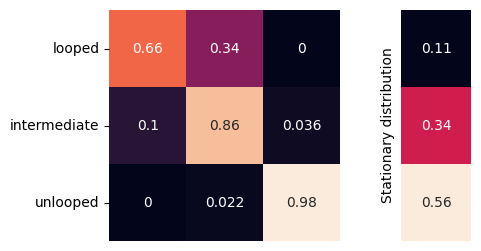

In [10]:
fig = tplt.plot_transition_matrix(tm2.P)

<Axes: >

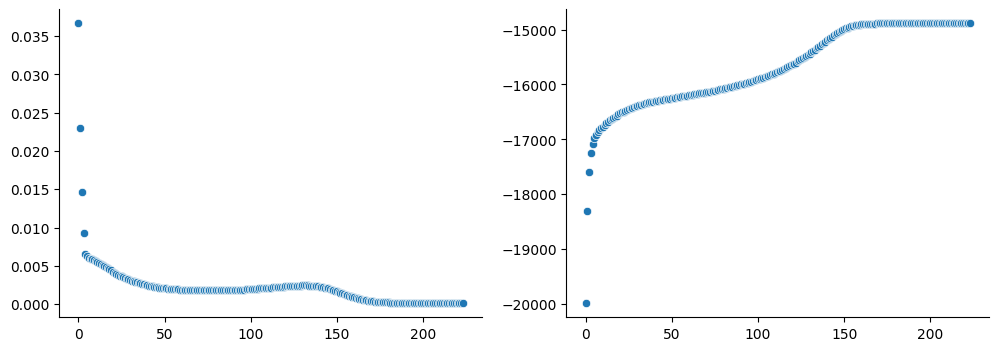

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.scatterplot(tm2.convergence, ax=axes[0])
sns.scatterplot(tm2.lklhd, ax=axes[1])

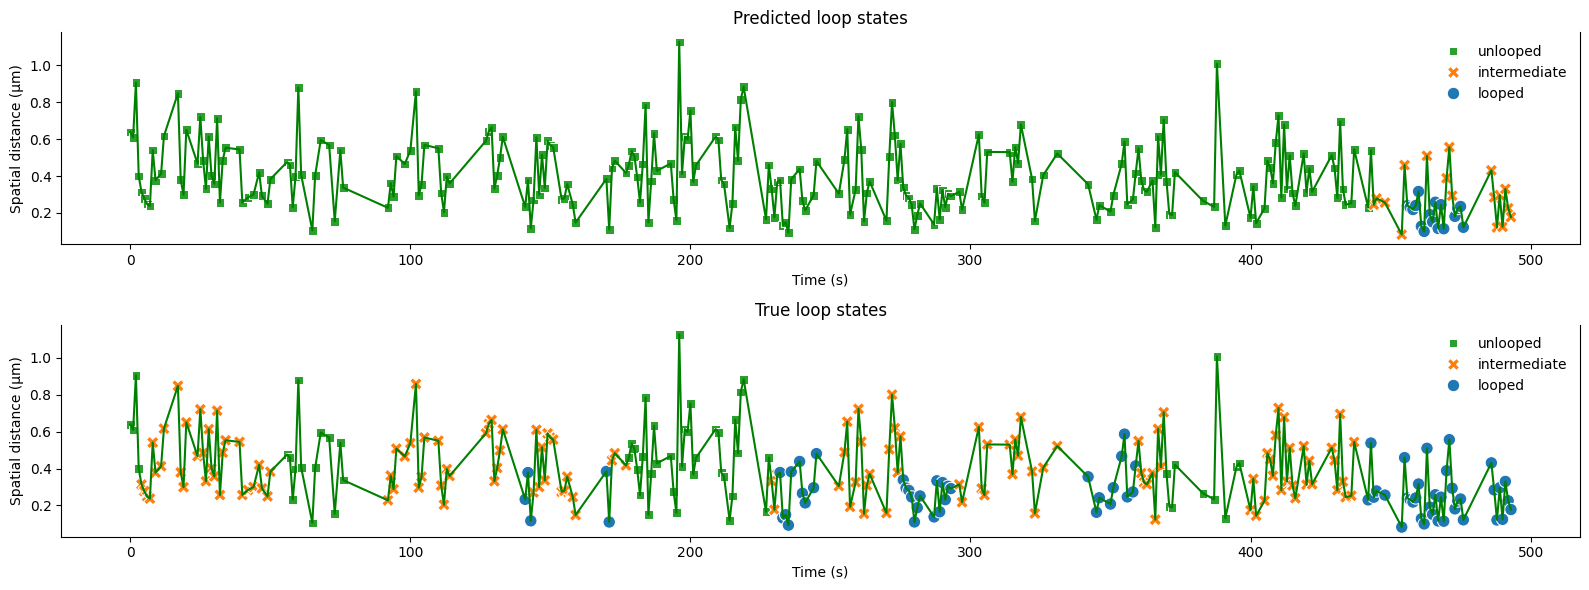

In [12]:
n = 1
dist = np.linalg.norm(X[n], axis=1)
df = pd.DataFrame({"dist":dist, "state":tm2.decode(X[[n]])[0]})
df = df.reset_index(names="t")
df["true"] = H[n]
code_book = {0:"looped", 1:"intermediate", 2:"unlooped"}
fig, axes = plt.subplots(2, 1, figsize=(16, 6))
tplt.plot_trace(df, "t", "dist", "state", code_book, fig, axes[0])
tplt.plot_trace(df, "t", "dist", "true", code_book, fig, axes[1])
axes[0].set(xlabel="Time (s)", ylabel="Spatial distance (µm)", title="Predicted loop states")
axes[1].set(xlabel="Time (s)", ylabel="Spatial distance (µm)", title="True loop states")
fig.tight_layout()